In [2]:
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
iris = datasets.load_iris()

#feature => petal length, petal width
X = iris.data[:, [2, 3]]

#클래스 라벨은 Iris-Setosa, Iris-Versicolour, Iris-Virginica
#순서에 따라 0, 1, 2로 표현
y = iris.target

#unique는 중복되지 않는 숫자들을 보여줌
print('class label:', np.unique(y))

class label: [0 1 2]


In [7]:
#X와 y 배열을 랜덤하게 나누어 훈련 데이터와 성능 테스트 데이터에 넣음
#즉 150개 중 30%는 테스트 데이터, 70%는 훈련 데이터로 배정
#stratify는 계층화
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 1, stratify = y)

In [8]:
#stratify = 클래스 레이블 비율을 입력 데이터셋과 동일하게 만듦
#즉 class label이 [0, 1, 2] 각각 동일한 비율을 갖도록 함
print('y label count', np.bincount(y))
print('y label count', np.bincount(y_train))
print('y label count', np.bincount(y_test))

y label count [50 50 50]
y label count [35 35 35]
y label count [15 15 15]


In [9]:
#feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [12]:
#perceptron 알고리즘 불러옴
from sklearn.linear_model import Perceptron

#scaling된 feature로 학습
ppn = Perceptron(eta0 = 0.1, random_state = 1)
ppn.fit(X_train_std, y_train)

#scaling된 테스트 데이터로 예측
prediction = ppn.predict(X_test_std)

#오류 개수 
print('오류 개수: %d' % (y_test != prediction).sum())

오류 개수: 1


In [13]:
#정확도 계산
from sklearn.metrics import accuracy_score
print('정확도: %.3f' % (accuracy_score(y_test, prediction)))

#또는 accuracy_scorer(X_test_std, prediction) 해도 동일

정확도: 0.978


In [21]:
#잘 분류하는지 시각화해서 확인해보기
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx = None, resolution = 0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() -1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha = 0.3, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0], 
                   y = X[y == cl, 1],
                   alpha = 0.8,
                   c = colors[idx],
                   marker = markers[idx],
                   label = cl,
                   edgecolor = 'black')
        if test_idx:
            X_test, y_test = X[test_idx, :], y[test_idx]
            
            plt.scatter(X_test[:, 0], X_test[:, 1],
                       facecolors = 'none', edgecolor = 'black', alpha = 1.0,
                       linewidth = 1, marker = 'o', s = 100, label = 'test set')

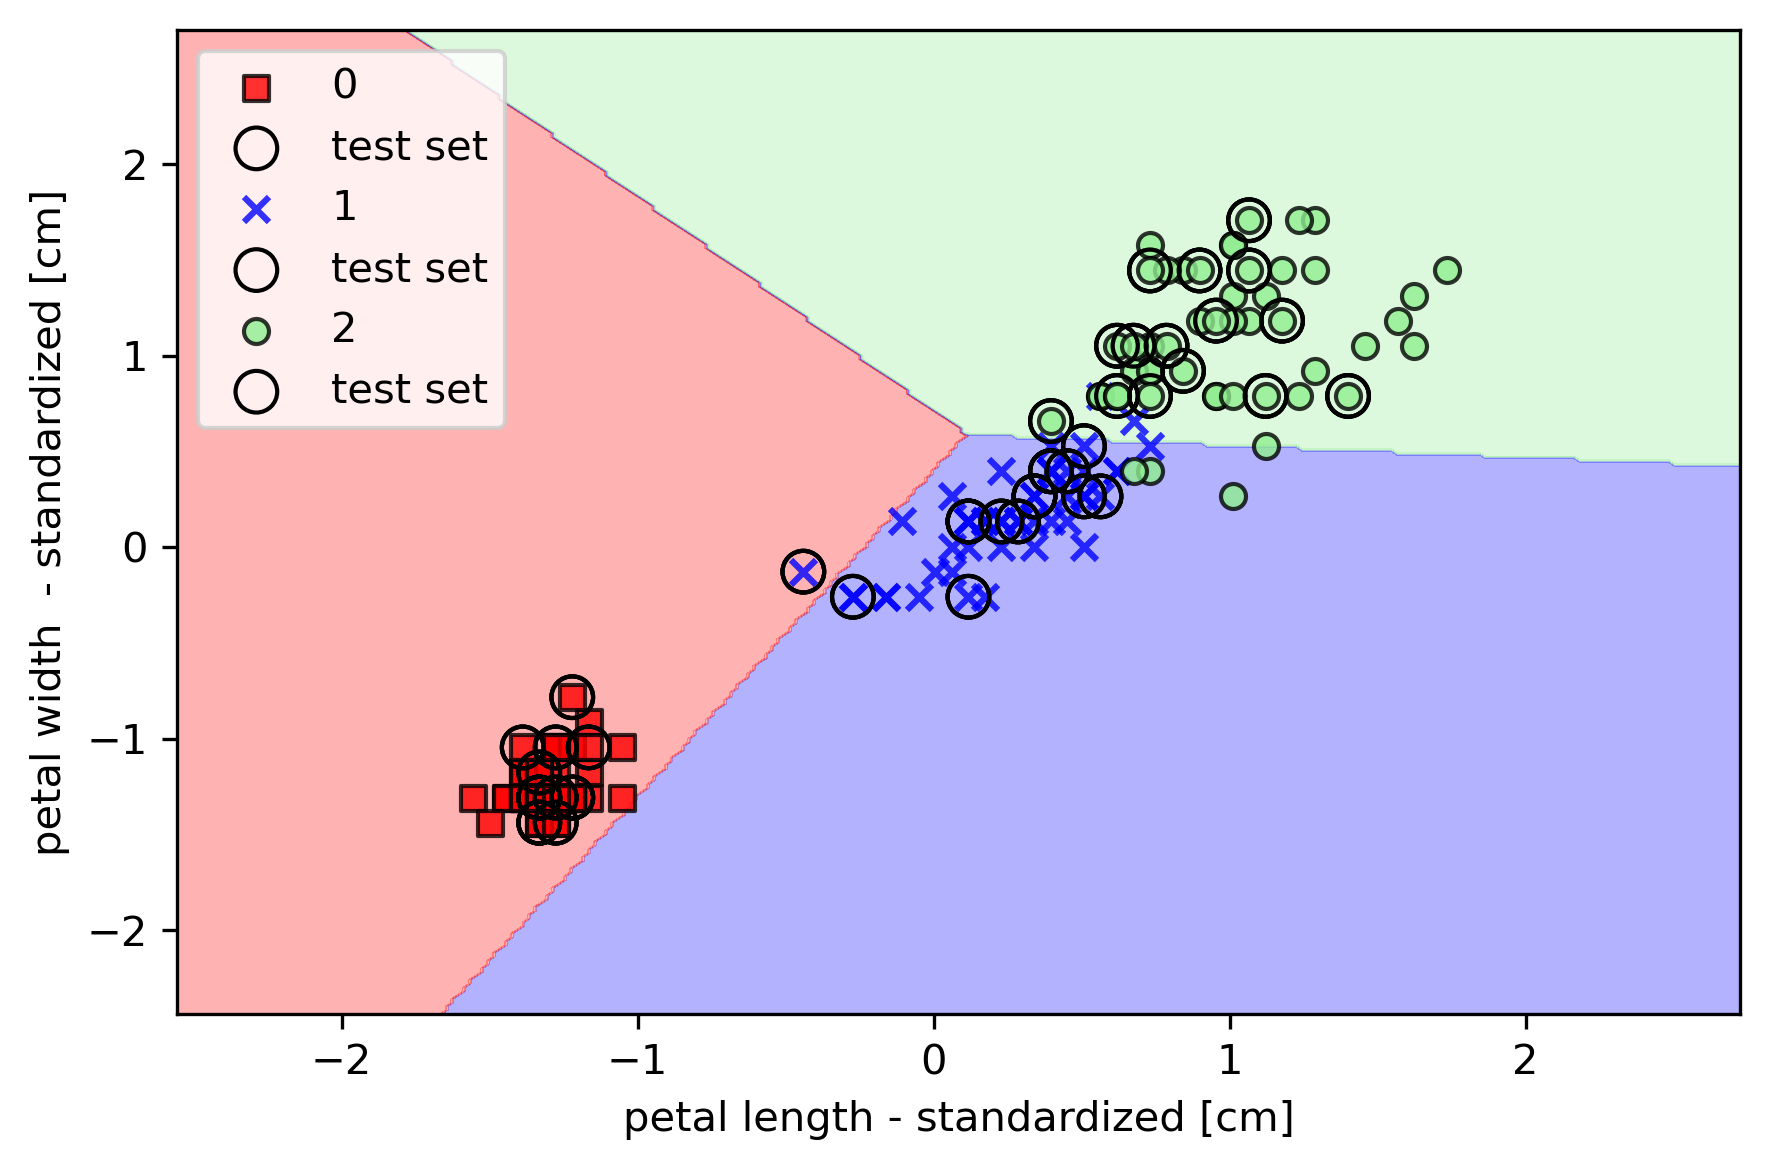

In [27]:
#perceptron 알고리즘으로 3개 분류는 별로 성공적이지 못함
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X = X_combined_std,
                     y = y_combined, classifier = ppn, test_idx = range(105, 150))
plt.xlabel('petal length - standardized [cm]')
plt.ylabel('petal width  - standardized [cm]')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

In [23]:
class LogisticRegressionGD(object):
    
    def __init__(self, eta = 0.05, n_iter = 100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y): 
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            #cost 비용 log 함수 공식 쓴 부분
            cost = (-y.dot(np.log(output))) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        #numpy.exp() 함수는 밑이 자연상수 e인 지수함수(e^x)로 변환
        #여기서는 e^z로 변환
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

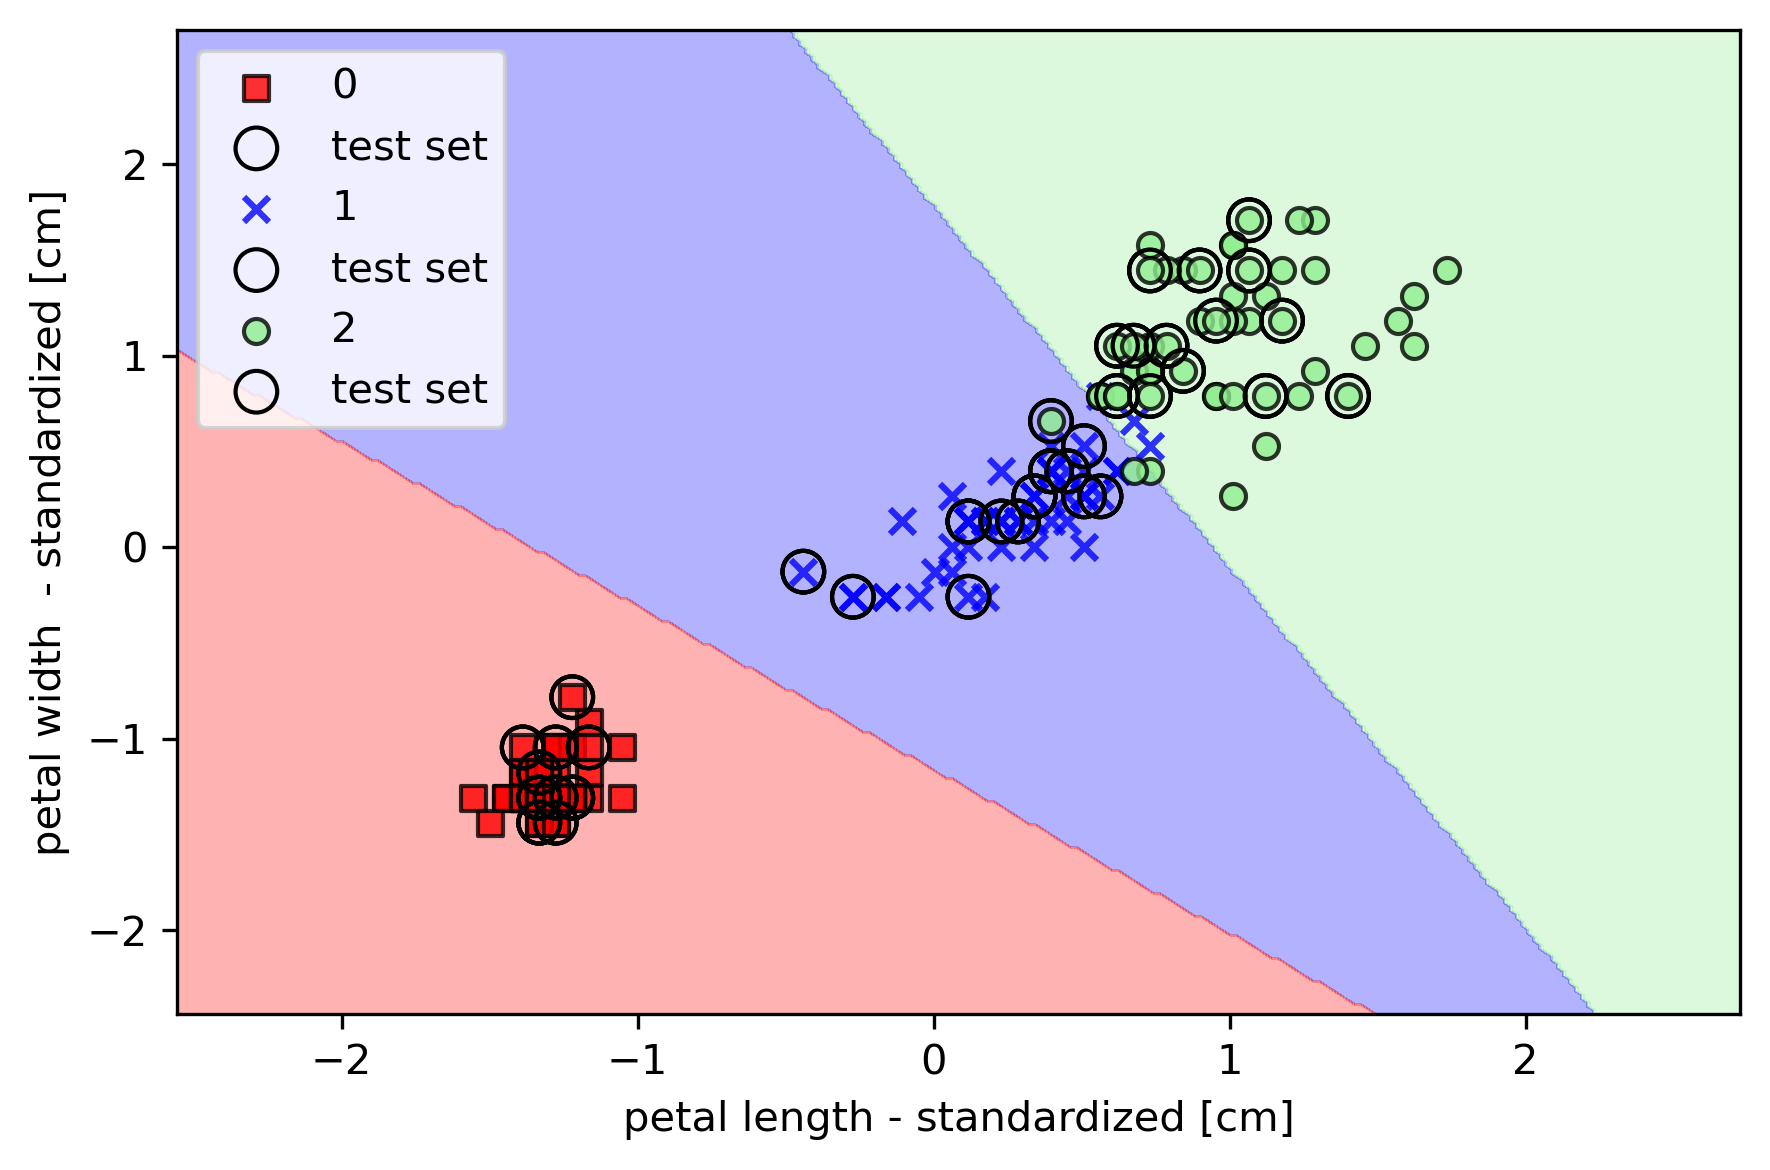

In [26]:
from sklearn.linear_model import LogisticRegression as lg
lr = lg(C = 100.0, random_state = 1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X = X_combined_std,
                     y = y_combined, classifier = lr, test_idx = range(105, 150))
plt.xlabel('petal length - standardized [cm]')
plt.ylabel('petal width  - standardized [cm]')
plt.legend(loc = 'upper left')
plt.rcParams["figure.dpi"] = 300
plt.tight_layout()
plt.show()